<a href="https://colab.research.google.com/github/Riyan-Dev/Automated-Glaucoma-Detection-using-Optic-Disc-and-Cup-Segmentation/blob/main/DIP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img

In [2]:
ground_truth_path = "/content/drive/MyDrive/ground truths"
images_path = "/content/drive/MyDrive/images"

In [3]:
image_files = sorted(os.listdir(images_path))
ground_truth_files = sorted(os.listdir(ground_truth_path))

In [4]:
image_files = sorted([f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))])
ground_truth_files = sorted([f for f in os.listdir(ground_truth_path) if os.path.isfile(os.path.join(ground_truth_path, f))])

In [5]:
# Verify alignment by printing pairs
for i in range(5):  # Example to check the first 5 pairs
    print(f"Image file: {image_files[i]}, Mask file: {ground_truth_files[i]}")

Image file: 1.png, Mask file: 1.tif
Image file: 10.png, Mask file: 10.tif
Image file: 100.png, Mask file: 100.tif
Image file: 11.png, Mask file: 11.tif
Image file: 12.png, Mask file: 12.tif


In [6]:
images = [cv2.imread(os.path.join(images_path, f)) for f in image_files]
ground_truths = [cv2.imread(os.path.join(ground_truth_path, f), cv2.IMREAD_GRAYSCALE) for f in ground_truth_files]

In [7]:
train_images, test_images, train_ground_truths, test_ground_truths = train_test_split(images, ground_truths, test_size=10, random_state=42)
print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")

Number of training images: 90
Number of testing images: 10


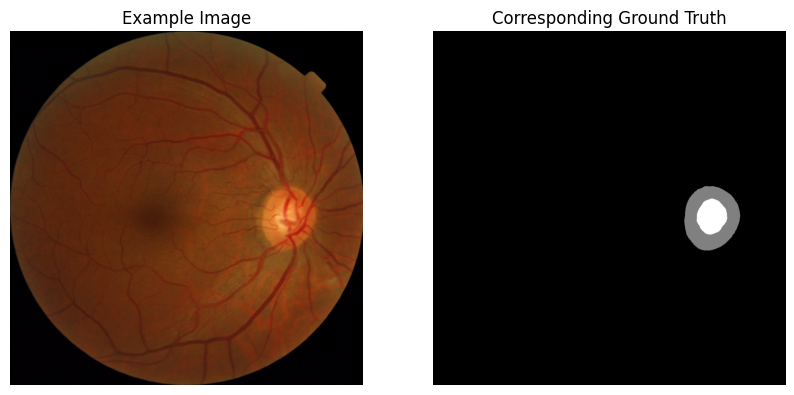

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.title("Example Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ground_truths[0], cv2.COLOR_BGR2RGB))
plt.title("Corresponding Ground Truth")
plt.axis('off')

plt.show()

In [34]:
TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 8  # Or adjust based on your dataset size
STEPS_PER_EPOCH = max(1, TRAIN_LENGTH // BATCH_SIZE)  # Ensures at least 1
BUFFER_SIZE = 100
width, height = 224, 224

In [14]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)  # Assuming masks are already [0, 1] or need conversion similar to images
    return input_image, input_mask

def preprocess_masks(mask):
    # Map 128 to 1, and everything else to 0 (assuming only two classes really exist)
    mask = tf.where(mask == 128, 1, 0)
    return mask

def load_image_and_mask(image, mask):
    image = tf.image.resize(image, [height, width])
    mask = preprocess_masks(mask)  # make sure mask values are correctly preprocessed
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    image, mask = normalize(image, mask)
    return image, mask

In [15]:
# Convert the lists to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_ground_truths))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_ground_truths))

In [16]:
# Apply the load_image_and_mask function
train_ds = train_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
# Setting up the training dataset pipeline
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# Setting up the testing dataset pipeline
test_ds = test_ds.batch(BATCH_SIZE)

In [19]:
for i in range(5):
    print(f"Image file: {image_files[i]}, Mask file: {ground_truth_files[i]}")

Image file: 1.png, Mask file: 1.tif
Image file: 10.png, Mask file: 10.tif
Image file: 100.png, Mask file: 100.tif
Image file: 11.png, Mask file: 11.tif
Image file: 12.png, Mask file: 12.tif


In [20]:
# Debug function to check unique mask values
def debug_mask_values(dataset):
    for images, masks in dataset.take(1):  # Take one batch from the dataset
        print("Unique mask labels in batch:", np.unique(masks.numpy()))

# Call this function after creating your dataset but before training
debug_mask_values(train_ds)

Unique mask labels in batch: [0. 1.]


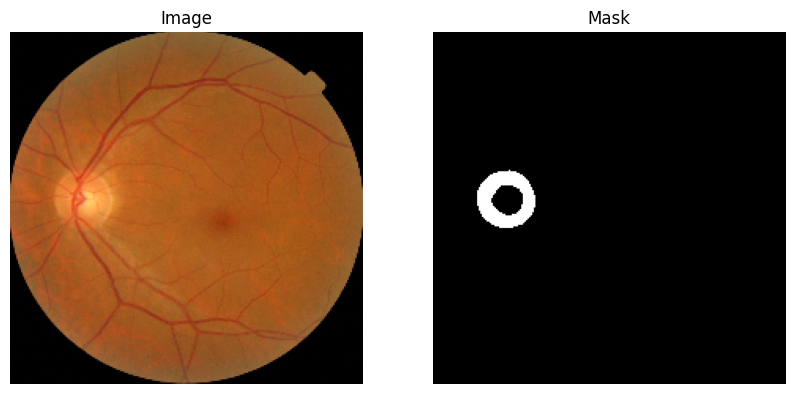

In [21]:
def display_sample(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Fetch one batch from the dataset
for images, masks in train_ds.take(1):
    sample_image, sample_mask = images[0], masks[0]  # Take the first example in the batch
    display_sample(sample_image.numpy(), sample_mask.numpy())  # Convert tensors to numpy arrays for visualization

In [22]:
base_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input, base_model_outputs)

In [23]:
def fcn8_decoder(convs, n_classes):
    f1, f2, f3, f4, p5 = convs

    n = 4096
    c6 = tf.keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7")(c6)

    f5 = c7

    # upsample the output of the encoder
    # then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(2, 2), use_bias=False)(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 4 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same'))(o2)

    # add the results of the upsampling and pool 4 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample the resulting tensor of the operation you just did
    o = (tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(2, 2), use_bias=False))(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 3 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f3
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same'))(o2)

    # add the results of the upsampling and pool 3 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8, 8),  strides=(8, 8), use_bias=False)(o)

    # append a softmax to get the class probabilities
    o = tf.keras.layers.Activation('softmax')(o)
    return o

In [24]:
def segmentation_model():

    inputs = keras.layers.Input(shape=(width, height, 3))
    convs = VGG_16(inputs)
    outputs = fcn8_decoder(convs, 3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [25]:
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        if i == 0:  # Assuming the first image in the display_list is the input image
            # Convert BGR to RGB
            img = display_list[i]
            img = img[..., ::-1]  # Reverse the last (channel) dimension to switch from BGR to RGB
            plt.imshow(array_to_img(img))
        else:
            plt.imshow(array_to_img(display_list[i]))

        plt.axis('off')
    plt.show()

In [44]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_images([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_images([sample_image, sample_mask,
                        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


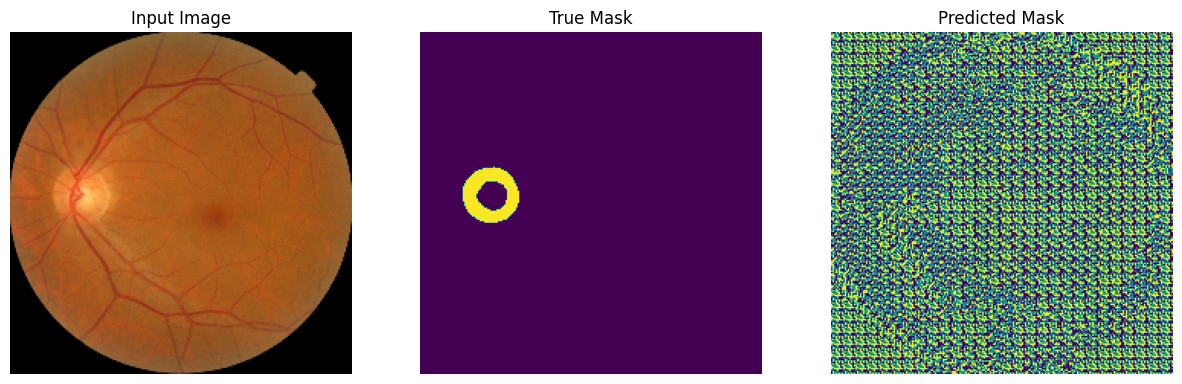

In [27]:
show_predictions()

In [35]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=max(1, len(test_images) // BATCH_SIZE // VAL_SUBSPLITS),  # Ensuring validation steps aren't zero
    validation_data=test_ds
)

Epoch 1/20
11/11 [==============================] - 202s 19s/step - loss: 0.3641 - accuracy: 0.8599 - val_loss: 0.2041 - val_accuracy: 0.9248
Epoch 2/20
11/11 [==============================] - 144s 14s/step - loss: 0.1249 - accuracy: 0.9580 - val_loss: 0.0724 - val_accuracy: 0.9656
Epoch 3/20
11/11 [==============================] - 149s 14s/step - loss: 0.0531 - accuracy: 0.9810 - val_loss: 0.0443 - val_accuracy: 0.9830
Epoch 4/20
11/11 [==============================] - 151s 14s/step - loss: 0.0419 - accuracy: 0.9845 - val_loss: 0.0446 - val_accuracy: 0.9861
Epoch 5/20
11/11 [==============================] - 151s 14s/step - loss: 0.0390 - accuracy: 0.9853 - val_loss: 0.0377 - val_accuracy: 0.9860
Epoch 6/20
11/11 [==============================] - 147s 13s/step - loss: 0.0366 - accuracy: 0.9856 - val_loss: 0.0370 - val_accuracy: 0.9864
Epoch 7/20
11/11 [==============================] - 145s 13s/step - loss: 0.0356 - accuracy: 0.9857 - val_loss: 0.0354 - val_accuracy: 0.9861
Epoch 

1/1 [==============================] - 1s 769ms/step


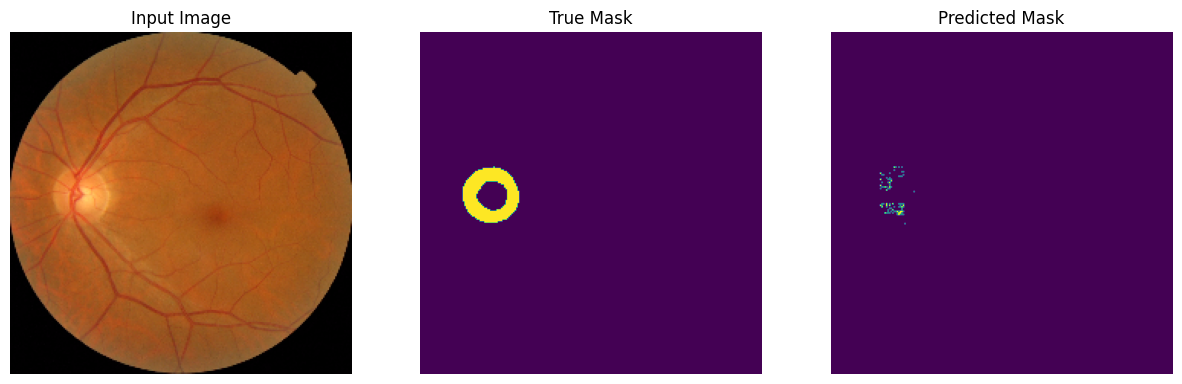

In [45]:
show_predictions()